# Import Libraries and Load Data

In [26]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gensim
from gensim.models import Word2Vec

import spacy
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Sample data
data = ["Natural Language Processing is fun!",
        "NLP is a subfield of AI.",
        "We can use NLP for chatbots, sentiment analysis, and more.",
        "Feature extraction is the foundation of many NLP tasks."]
df = pd.DataFrame({'text': data})


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


# Preprocessing the Text

In [15]:
def preprocess(text):
    text = text.lower()  # lowercase
    text = re.sub(rf"[{string.punctuation}]", "", text)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    return tokens

df["tokens"] = df["text"].apply(preprocess)
df["clean_text"] = df["tokens"].apply(lambda x: " ".join(x))
df.head()


,text,tokens,clean_text
0,Natural Language Processing is fun!,"[natural, language, processing, is, fun]",natural language processing is fun
1,NLP is a subfield of AI.,"[nlp, is, a, subfield, of, ai]",nlp is a subfield of ai
2,"We can use NLP for chatbots, sentiment analysi...","[we, can, use, nlp, for, chatbots, sentiment, ...",we can use nlp for chatbots sentiment analysis...
3,Feature extraction is the foundation of many N...,"[feature, extraction, is, the, foundation, of,...",feature extraction is the foundation of many n...


# One-Hot Encoding

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(df['tokens'])
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df.head()


,a,ai,analysis,and,can,chatbots,extraction,feature,for,foundation,...,natural,nlp,of,processing,sentiment,subfield,tasks,the,use,we
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,0,0,1,1,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
3,0,0,0,0,0,0,1,1,0,1,...,0,1,1,0,0,0,1,1,0,0


# Bag of Words (BoW)

In [17]:
cv = CountVectorizer()
bow = cv.fit_transform(df["clean_text"])
bow_df = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names_out())
bow_df.head()


,ai,analysis,and,can,chatbots,extraction,feature,for,foundation,fun,...,natural,nlp,of,processing,sentiment,subfield,tasks,the,use,we
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,0,1,1,1,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
3,0,0,0,0,0,1,1,0,1,0,...,0,1,1,0,0,0,1,1,0,0


# N-Grams (Unigrams, Bigrams, Trigrams)

In [18]:
# Unigrams
cv_uni = CountVectorizer(ngram_range=(1, 1))
# Bigrams
cv_bi = CountVectorizer(ngram_range=(2, 2))
# Trigrams
cv_tri = CountVectorizer(ngram_range=(3, 3))

print("Unigrams:\n", cv_uni.fit_transform(df["clean_text"]).toarray())
print("\nBigrams:\n", cv_bi.fit_transform(df["clean_text"]).toarray())
print("\nTrigrams:\n", cv_tri.fit_transform(df["clean_text"]).toarray())


Unigrams:
 [[0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]
 [0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0]]

Bigrams:
 [[0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0]
 [1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1]
 [0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0]]

Trigrams:
 [[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1]
 [0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0]]


# TF-IDF

In [19]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df["clean_text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head()


,ai,analysis,and,can,chatbots,extraction,feature,for,foundation,fun,...,natural,nlp,of,processing,sentiment,subfield,tasks,the,use,we
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.47633,...,0.47633,0.000000,0.000000,0.47633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.539445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.344321,0.425305,0.00000,0.000000,0.539445,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.326036,0.326036,0.326036,0.326036,0.000000,0.000000,0.326036,0.000000,0.00000,...,0.00000,0.208104,0.000000,0.00000,0.326036,0.000000,0.000000,0.000000,0.326036,0.326036
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.366706,0.366706,0.000000,0.366706,0.00000,...,0.00000,0.234064,0.289115,0.00000,0.000000,0.000000,0.366706,0.366706,0.000000,0.000000


# Word2Vec

In [20]:
# Using Gensim
model = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv
word_vectors['nlp']  # Example: get vector for "nlp"


array([-8.6163217e-03,  3.6621247e-03,  5.1905848e-03,  5.7397997e-03,
        7.4679321e-03, -6.1660125e-03,  1.1080153e-03,  6.0491795e-03,
       -2.8395685e-03, -6.1746589e-03, -4.0872814e-04, -8.3690789e-03,
       -5.6022229e-03,  7.1077179e-03,  3.3491959e-03,  7.2231605e-03,
        6.8047405e-03,  7.5341058e-03, -3.7877350e-03, -5.6553003e-04,
        2.3480032e-03, -4.5207338e-03,  8.3930911e-03, -9.8574776e-03,
        6.7649162e-03,  2.9156401e-03, -4.9347430e-03,  4.3976326e-03,
       -1.7399989e-03,  6.7121363e-03,  9.9671576e-03, -4.3592076e-03,
       -5.9893104e-04, -5.6939283e-03,  3.8471757e-03,  2.7845809e-03,
        6.8863393e-03,  6.0970606e-03,  9.5379008e-03,  9.2686089e-03,
        7.8998106e-03, -6.9903294e-03, -9.1518043e-03, -3.5799370e-04,
       -3.1000092e-03,  7.8967167e-03,  5.9367968e-03, -1.5504938e-03,
        1.5089380e-03,  1.7903800e-03,  7.8174630e-03, -9.5147593e-03,
       -2.0813772e-04,  3.4683587e-03, -9.4191782e-04,  8.3771478e-03,
      

# Visualize Embeddings (PCA & t-SNE)

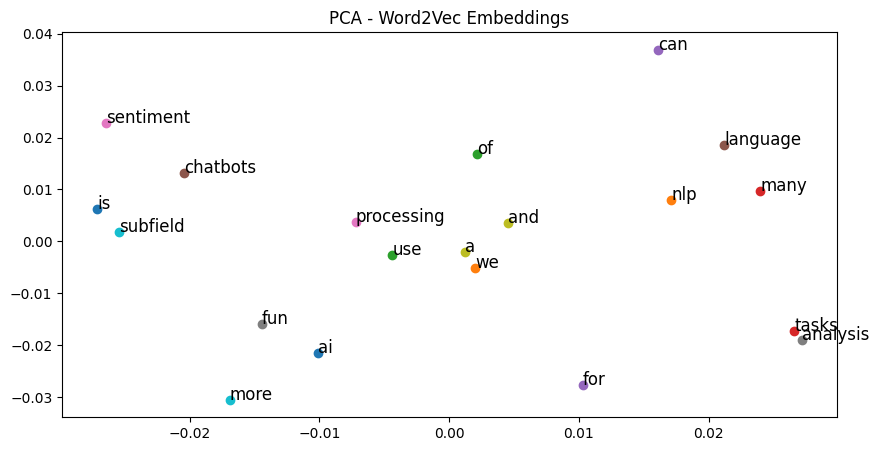

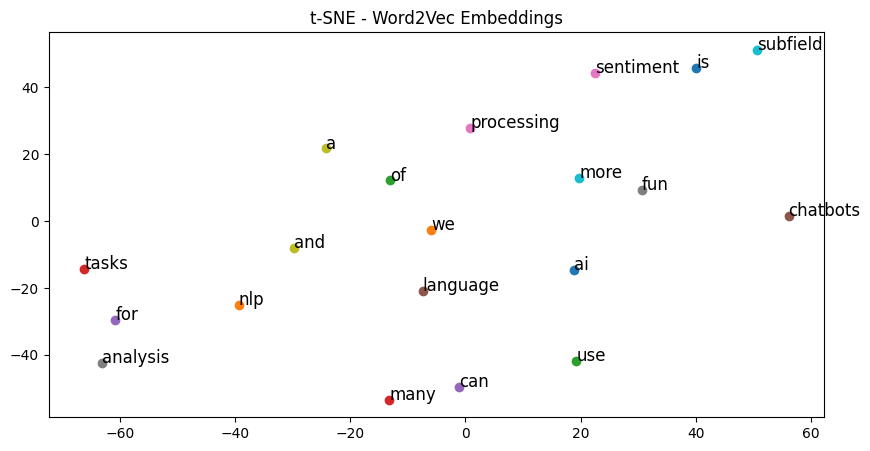

In [22]:
# Pick top N words
words = list(word_vectors.index_to_key)[:20]
vectors = np.array([word_vectors[word] for word in words])

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectors)

plt.figure(figsize=(10,5))
plt.title("PCA - Word2Vec Embeddings")
for i, word in enumerate(words):
    plt.scatter(*pca_result[i])
    plt.annotate(word, xy=pca_result[i], fontsize=12)
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=0)
tsne_result = tsne.fit_transform(vectors)

plt.figure(figsize=(10,5))
plt.title("t-SNE - Word2Vec Embeddings")
for i, word in enumerate(words):
    plt.scatter(*tsne_result[i])
    plt.annotate(word, xy=tsne_result[i], fontsize=12)
plt.show()
